In [121]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image

In [122]:
# Define constants
g = 1.0           # Atom-cavity coupling strength
kappa = 1.0       # Cavity decay rate
gamma = 0.5       # Atomic spontaneous emission rate
T = 10            # Pulse duration
n_photon = 2      # Photon number states: 0 or 1
n_atom = 3        # Atom: |0>, |1>, |e>

# Basis states
# Atom: |0>, |1>, |e> → index 0, 1, 2
# Photon: |h>, |v> → index 0, 1

In [158]:
def input_shape(x:float) -> float:
    return np.exp(-(x-T/2)**2/(T/5)**2)

In [159]:
# Time list
tlist = np.linspace(0, T, 500)

In [160]:
# Identity operators
I_atom = qeye(n_atom)
I_photon = qeye(n_photon)

In [161]:
# Light operators
a_h = tensor(destroy(n_photon),I_atom)
a_h_dag = a_h.dag()
a_h

Quantum object: dims=[[2, 3], [2, 3]], shape=(6, 6), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

In [162]:
# Atom Operators
excitation = tensor(I_photon,basis(n_atom,2) * basis(n_atom,1).dag())
relaxation = excitation.dag()

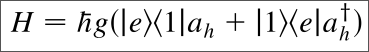

In [163]:
Image("pictures/cpf_gate_hamiltonian.png")

In [164]:
H_jc = g*(excitation*a_h + relaxation*a_h_dag)

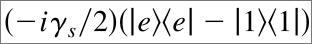

In [165]:
Image("pictures/spont_emission_noise.png")

In [166]:
# Collapse operators
'''c_ops = [
    np.sqrt(kappa) * tensor(I_atom, a),             # Cavity decay
    np.sqrt(gamma) * tensor(basis(n_atom, 0) * basis(n_atom, 2).dag(), I_cavity),  # |e> → |0>
    np.sqrt(gamma) * tensor(basis(n_atom, 1) * basis(n_atom, 2).dag(), I_cavity),  # |e> → |1>
]'''
c_ops = [
    (gamma/2j) * tensor(I_photon,basis(n_atom,2)*basis(n_atom,2).dag() - basis(n_atom,1)*basis(n_atom,1).dag())
]
c_ops[0]


Quantum object: dims=[[2, 3], [2, 3]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j  ]
 [0.+0.j   0.+0.25j 0.+0.j   0.+0.j   0.+0.j   0.+0.j  ]
 [0.+0.j   0.+0.j   0.-0.25j 0.+0.j   0.+0.j   0.+0.j  ]
 [0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j  ]
 [0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.25j 0.+0.j  ]
 [0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.+0.j   0.-0.25j]]

In [167]:
# Atom initial state: (|0> + |1>) / sqrt(2)
psi_atom = (basis(n_atom, 0) + basis(n_atom, 1)).unit()

# Cavity initial state: 1 photon (|1>)
psi_cavity = basis(n_photon, 1)

# Full initial state
psi0 = tensor(psi_cavity, psi_atom)

In [171]:
pulse_scale = 10  # small enough so that max photons in cavity ≈ 1
H_drive = [pulse_scale * a_h_dag, input_shape]

In [174]:
# Evolve

H = [H_jc, H_drive]

result = mesolve(H, psi0, tlist,[],[a_h_dag*a_h, relaxation*excitation])

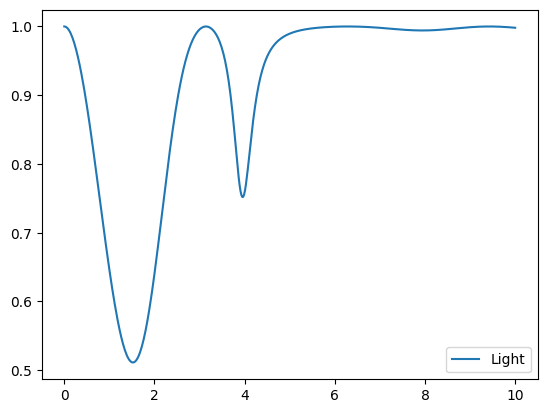

In [175]:
plt.plot(tlist, result.expect[0], label="Light")
plt.legend();

ValueError: x and y must have same first dimension, but have shapes (500,) and (0,)

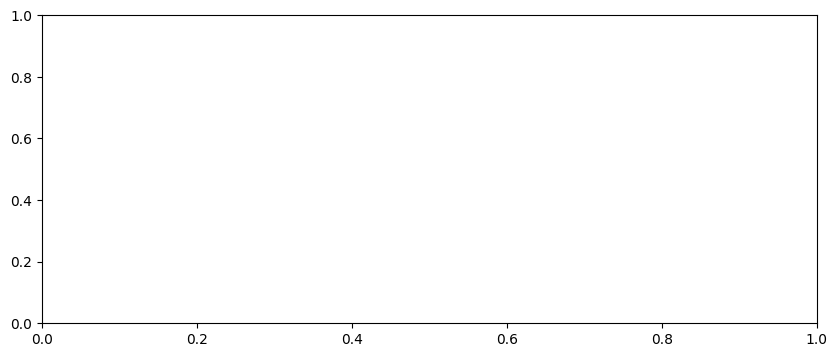

In [180]:
photon_op = tensor(a_h_dag * a_h)
n_photon_0 = expect(photon_op, result.states)

# Plot photon number as proxy for output pulse shape
plt.figure(figsize=(10, 4))
plt.plot(tlist, n_photon_0, label="Atom in |0⟩ (with interaction)")
#plt.plot(tlist, n_photon_1, label="Atom in |1⟩ (no interaction)", linestyle="--")
plt.title("Simulated Output Photon Profile")
plt.xlabel("Time")
plt.ylabel("⟨Photon Number⟩")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()